In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CHANGE PROJECT WORKING DIRECTORY TO NOTEBOOK'S DIRECTORY



In [4]:
import os
!pwd
Notebook_dir = "/content/drive/MyDrive/Colab Notebooks/Notebooks/Licence_Detection/License_Plate_Detector/1_Prepare_data/Notebooks"
os.chdir(Notebook_dir)
!pwd

/content
/content/drive/MyDrive/Colab Notebooks/Notebooks/Licence_Detection/License_Plate_Detector/1_Prepare_data/Notebooks


DOWNLOAD DATASET

In [ ]:
!kaggle datasets download andrewmvd/car-plate-detection

!unzip -qo face-mask-detection.zip -d ../Data

CREAT DATASET CLASS

In [5]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import xml.etree.ElementTree as ET

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        # load images and annotations
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annotation_path = os.path.join(self.root, "annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        tree = ET.parse(annotation_path) 
        root = tree.getroot() 
        # get bounding box coordinates
        num_objs = 0
        boxes = []
        for member in root.findall('object'):
            class_name = member[0].text # class name

            # bbox coordinates
            xmin = int(member[5][0].text)
            ymin = int(member[5][1].text)
            xmax = int(member[5][2].text)
            ymax = int(member[5][3].text)
            boxes.append([xmin, ymin, xmax, ymax])
            num_objs += 1

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
#Check output of dataset class

dataset = CarDataset('../Data')
dataset[53]

(<PIL.Image.Image image mode=RGB size=400x300 at 0x7FAA23070B90>,
 {'area': tensor([216., 234., 168., 180.]),
  'boxes': tensor([[143., 263., 170., 271.],
          [254., 238., 280., 247.],
          [ 54., 189.,  78., 196.],
          [111., 194., 129., 204.]]),
  'image_id': tensor([53]),
  'iscrowd': tensor([0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1])})

RANDOMLY INSPECT DATASET

In [8]:
import cv2
import matplotlib.pyplot as plt
import random

def display_rand_images():
    dataset = CarDataset('../Data')
    for i in range(0, 9):
        index = random.randint(0, len(dataset) - 1)
        image = dataset[index + 1][0].copy()
        box = np.array(dataset[index + 1][1]["boxes"][0])
        imag = cv2.rectangle(np.asarray(image), (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,0,255), 2)
        im_pil = Image.fromarray(imag)
        plt.subplot(3, 3, i + 1)
        plt.imshow(im_pil)

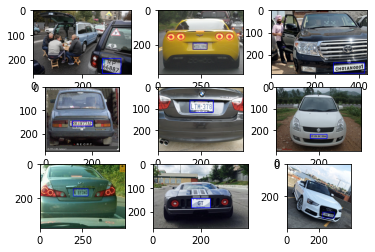

In [9]:
display_rand_images()

BUILD DETECTION MODEL

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_detection_model(num_classes):
    # load an detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [11]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.PILToTensor())
    transforms.append( T.ConvertImageDtype(torch.float32))
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


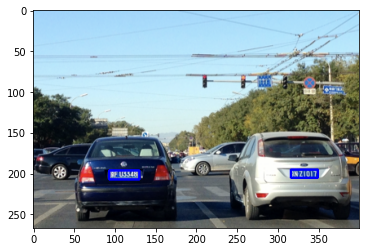

In [55]:

# apply the transforms to a sample image
dataset = CarDataset('../Data', get_transform(train = True))
test_num = 50
img, targets = dataset[test_num]

fig = plt.figure()
image = img.numpy()
image = np.swapaxes(image, 0, 2)
image = np.swapaxes(image, 0, 1)
for box in targets["boxes"] :
    imag = cv2.rectangle(image , (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,0,255), 2)


plt.imshow(imag)

In [56]:
# use our dataset and defined transformations
dataset = CarDataset('../Data', get_transform(train=True))
dataset_test = CarDataset('../Data', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [57]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [58]:
# let's train it for 10 epochs
import torch
from torch.optim.lr_scheduler import StepLR
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    #save model after every epoch
    torch.save(model.state_dict(), "trained_models/mobile_net_model_epoch_{}.pt".format(epoch))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [0]  [  0/192]  eta: 2:35:38  lr: 0.000031  loss: 1.0471 (1.0471)  loss_classifier: 0.9670 (0.9670)  loss_box_reg: 0.0122 (0.0122)  loss_objectness: 0.0576 (0.0576)  loss_rpn_box_reg: 0.0103 (0.0103)  time: 48.6374  data: 0.8322


KeyboardInterrupt: ignored

INFERENCE

In [59]:
#Load Trained Model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_detection_model(2)
# move model to the right device

model.load_state_dict(torch.load("trained_models/mobile_net_model_epoch.pt",map_location=torch.device('cpu')))
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

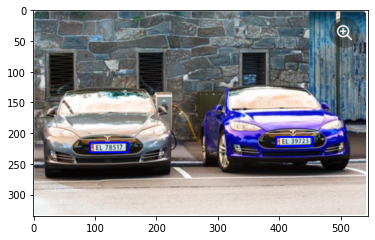

In [62]:
import cv2
import matplotlib.pyplot as plt
import random

                                
image = cv2.imread("../test/images/Capture2.PNG")
orig = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, axis=0)
image = image / 255.0

image = torch.FloatTensor(image)
image = image.to(device)

model.eval()
with torch.no_grad():
    prediction = model(image)
fig = plt.figure()


for box in prediction[0]["boxes"][:2] :
    imag = cv2.rectangle(orig, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,0,255), 2)

plt.imshow(imag, cmap = 'gray')

In [ ]:
!bash

bash: cannot set terminal process group (58): Inappropriate ioctl for device
bash: no job control in this shell
_Detector/1_Prepare_data/Notebooks# git status
On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Untitled.ipynb
	modified:   coco_eval.py
	modified:   coco_utils.py
	modified:   engine.py
	modified:   models.py
	modified:   transforms.py
	modified:   utils.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	../Data/
	__pycache__/
	car-plate-detection.zip
	trained_models/
	vision/
	../test/

no changes added to commit (use "git add" and/or "git commit -a")
_Detector/1_Prepare_data/Notebooks# 